## 1. Context
TechNova Solutions, a mid-sized IT services company with 1,200 employees, faces an attrition rate above industry standards. Despite competitive salaries and benefits, the company struggles to retain talent, especially in technical and client-facing roles. This turnover increases costs, delays projects, and reduces employee satisfaction. This project focuses on employee attrition, a major challenge faced by many organizations. High turnover rates can lead to increased recruitment costs, loss of expertise, and reduced productivity. By analyzing employee data, we aim to uncover patterns and factors that influence whether employees stay or leave. Understanding these drivers allows HR teams to take proactive steps to improve retention.


## 2. Problem Statement
Employee attrition can affect an organization’s performance, profitability, and morale. Hired as a Data Scientist, the challenge is to accurately identify employees who are at risk of leaving based on their personal, professional, and behavioral characteristics. By building a predictive model, I aim to support HR in making data-informed decisions to reduce churn.

a. Proactive prediction is critical to overcome the reactive approach.
b. Targeted interventions for high performers can enhance retention.

## 3. Objective
The main objective is to develop a machine learning model that can predict whether an employee is likely to leave the company. Additionally, I aim to:

1. Explore and understand the dataset thoroughly

2. Identify key factors influencing employee attrition.

3. Preprocess and transform data for effective modeling.

4. Build and evaluate predictive models.

5. Derive actionable insights and recommendations for HR.


## 4. Data Understanding
The dataset contains various employee-related attributes such as demographics, job information, performance metrics, and churn labels. Before proceeding, it’s crucial to examine the structure, data types, and basic statistics of the dataset.


In [125]:
# Pandas display setting
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)       

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('employee_churn_dataset.csv')
df.head()

,Employee ID,Age,Gender,Education Level,Marital Status,Tenure,Job Role,Department,Salary,Work Location,Performance Rating,Projects Completed,Training Hours,Promotions,Overtime Hours,Satisfaction Level,Work-Life Balance,Average Monthly Hours Worked,Absenteeism,Distance from Home,Manager Feedback Score,Churn
0,E00001,50,Male,Bachelor's,Married,5,Analyst,Marketing,93422,Remote,5,37,35,0,16,0.03,Poor,155,14,15,7.9,0
1,E00002,36,Male,Bachelor's,Married,4,Manager,Sales,44589,On-site,2,43,1,0,12,0.39,Average,162,2,8,5.2,0
2,E00003,29,Male,Bachelor's,Married,3,Sales,IT,56768,Hybrid,1,38,41,0,2,0.62,Poor,243,6,21,6.3,0
3,E00004,42,Male,Bachelor's,Single,12,Analyst,Sales,79009,On-site,1,39,33,0,8,0.73,Good,291,11,25,7.4,0
4,E00005,40,Other,Bachelor's,Married,1,Sales,HR,81982,On-site,3,49,30,0,13,0.52,Average,272,3,1,4.1,0


### Findings / Observations:
The initial look at the data shows a healthy mix of numerical and categorical features.
We have concrete data points like Tenure and Salary, alongside more subjective, yet critical, columns like Satisfaction Level and Work-Life Balance. 
This combination suggests a rich dataset for capturing both hard and soft factors driving churn.

1. The target variable Churn is already encoded as 0 (stay) and 1 (leave).

2. No obvious anomalies were detected at this stage.

In [129]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Employee ID                   10000 non-null  object 
 1   Age                           10000 non-null  int64  
 2   Gender                        10000 non-null  object 
 3   Education Level               10000 non-null  object 
 4   Marital Status                10000 non-null  object 
 5   Tenure                        10000 non-null  int64  
 6   Job Role                      10000 non-null  object 
 7   Department                    10000 non-null  object 
 8   Salary                        10000 non-null  int64  
 9   Work Location                 10000 non-null  object 
 10  Performance Rating            10000 non-null  int64  
 11  Projects Completed            10000 non-null  int64  
 12  Training Hours                10000 non-null  int64  
 13  Pr

In [131]:
missing_values = df.isna().sum()
print(missing_values)

Employee ID                     0
Age                             0
Gender                          0
Education Level                 0
Marital Status                  0
Tenure                          0
Job Role                        0
Department                      0
Salary                          0
Work Location                   0
Performance Rating              0
Projects Completed              0
Training Hours                  0
Promotions                      0
Overtime Hours                  0
Satisfaction Level              0
Work-Life Balance               0
Average Monthly Hours Worked    0
Absenteeism                     0
Distance from Home              0
Manager Feedback Score          0
Churn                           0
dtype: int64


### Findings / Observations:
It's a clean dataset of 10,000 rows and 22 columns. with no missing values in any column—a great start that bypasses the need for immediate data cleaning.

In [133]:
print(df.duplicated())

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 10000, dtype: bool


### Findings / Observations:
There are no duplicate employee records in the entire dataset. 
This is crucial for maintaining the integrity of our model, ensuring I don't skew the results by counting the same employee multiple times

In [135]:
print(df.nunique())

Employee ID                     10000
Age                                38
Gender                              3
Education Level                     4
Marital Status                      3
Tenure                             15
Job Role                            4
Department                          4
Salary                           9566
Work Location                       3
Performance Rating                  5
Projects Completed                 50
Training Hours                    100
Promotions                          2
Overtime Hours                     50
Satisfaction Level                101
Work-Life Balance                   4
Average Monthly Hours Worked      150
Absenteeism                        20
Distance from Home                 50
Manager Feedback Score             91
Churn                               2
dtype: int64


### Findings/Observations
The counts show that the categorical features have been properly converted into binary columns with two unique values (True/False or 0/1). 
The high cardinality in Salary (9566) is expected for a continuous variable.
It’s good to confirm that the unique Employee ID count matches the total number of rows.

## 5. Feature Engineering
Create new features to enhance prediction.

In [137]:
# Workload Index
df['Workload_Index'] = df['Average Monthly Hours Worked'] / df['Projects Completed'].replace(0, 1)

# Engagement Score
df['Engagement_Score'] = df['Satisfaction Level'] + df['Manager Feedback Score']



In [139]:
print("New Feature Columns:")
print(df[['Workload_Index', 'Engagement_Score']].head())

New Feature Columns:
   Workload_Index  Engagement_Score
0        4.189189              7.93
1        3.767442              5.59
2        6.394737              6.92
3        7.461538              8.13
4        5.551020              4.62


In [141]:
#View the New Features with Related Input Columns to see the new features side-by-side with the columns used to create them to manually verify the calculation.

print("Features and their Inputs:")
print(df[[
    'Average Monthly Hours Worked',
    'Projects Completed',
    'Satisfaction Level',
    'Manager Feedback Score',
    'Workload_Index',
    'Engagement_Score'
]].head(10))

Features and their Inputs:
   Average Monthly Hours Worked  Projects Completed  Satisfaction Level  Manager Feedback Score  Workload_Index  Engagement_Score
0                           155                  37                0.03                     7.9        4.189189              7.93
1                           162                  43                0.39                     5.2        3.767442              5.59
2                           243                  38                0.62                     6.3        6.394737              6.92
3                           291                  39                0.73                     7.4        7.461538              8.13
4                           272                  49                0.52                     4.1        5.551020              4.62
5                           266                   4                0.06                     2.1       66.500000              2.16
6                           233                  37            

In [143]:
print("Features and their Inputs")

# Use to_string() on the selected head(5) to get a print-ready, un-wrapped table
print(df[[
    'Average Monthly Hours Worked',
    'Projects Completed',
    'Satisfaction Level',
    'Manager Feedback Score',
    'Workload_Index',
    'Engagement_Score'
]].head().to_string())

Features and their Inputs
   Average Monthly Hours Worked  Projects Completed  Satisfaction Level  Manager Feedback Score  Workload_Index  Engagement_Score
0                           155                  37                0.03                     7.9        4.189189              7.93
1                           162                  43                0.39                     5.2        3.767442              5.59
2                           243                  38                0.62                     6.3        6.394737              6.92
3                           291                  39                0.73                     7.4        7.461538              8.13
4                           272                  49                0.52                     4.1        5.551020              4.62


In [145]:
#Check Descriptive Statistics distribution to spot outliers or unexpected values (like infinities, or NaNs).
print("Descriptive Statistics for New Features:")
print(df[['Workload_Index', 'Engagement_Score']].describe())

Descriptive Statistics for New Features:
       Workload_Index  Engagement_Score
count    10000.000000      10000.000000
mean        24.262646          6.060370
std         45.645557          2.610435
min          3.081633          1.000000
25%          6.057143          3.830000
50%          9.290323          6.100000
75%         18.666667          8.300000
max        299.000000         10.990000


### Findings/Observations
- `Workload_Index` may indicate overwork-related churn.
- `Engagement_Score` captures morale, potentially predictive.

Both the Workload and Engagement indices appear to be successfully calculated. 
However, the Workload_Index is highly right-skewed (Mean 24.26, Max 299.00). 
This massive outlier suggests that a small minority of employees are facing extremely high workloads, 
which will likely be a key driver of churn and might require scaling later. The Engagement_Score is well-behaved, ranging from 1.0 to 10.99.

## 6. Exploratory Data Analysis (EDA)
EDA helps uncover hidden patterns and relationships in the data. I examined distributions, correlations, and categorical breakdowns to gain deeper insights.



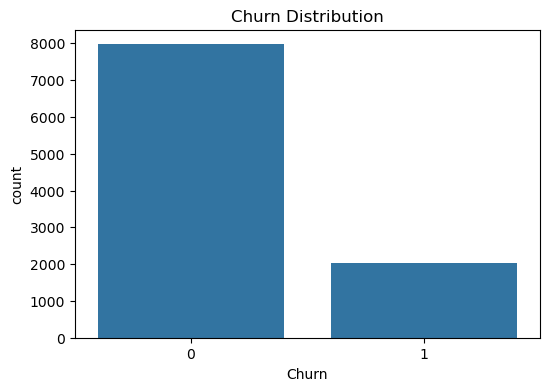

Churn Rate: 0.2028


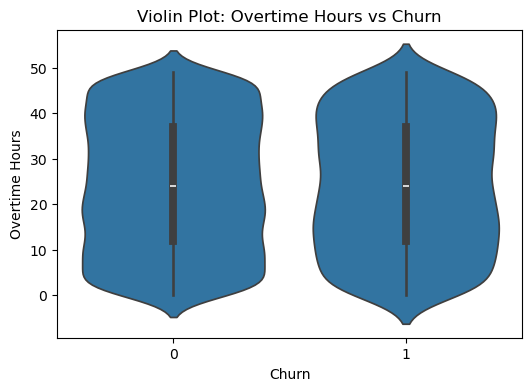

In [11]:
# Churn distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()
print("Churn Rate:", df['Churn'].mean())

# Violin plot for Overtime Hours vs Churn
plt.figure(figsize=(6, 4))
sns.violinplot(x='Churn', y='Overtime Hours', data=df)
plt.title('Violin Plot: Overtime Hours vs Churn')
plt.show()




# Findings / Observations:
### 1. Churn Distribution

The bar chart shows the count of employees who churned (1) versus those who did not churn (0).

Observation:

a. The dataset is imbalanced, with around 80% of employees not churning and 20% churning (Churn Rate ≈ 0.2028).

This imbalance is important to consider when building predictive models, as classifiers might be biased toward predicting "no churn."

## 2. Overtime Hours vs Churn (Violin Plot)

The violin plot shows the distribution of overtime hours for employees who churned and did not churn.

Observation:

a. Both churned and non-churned employees have similar median overtime hours (~25 hours).

b. The range of overtime hours is also similar for both groups (0–49 hours).

c. There is no strong visible difference in overtime hours between employees who churned and those who did not.

This suggests that overtime hours alone may not be a strong predictor of churn.



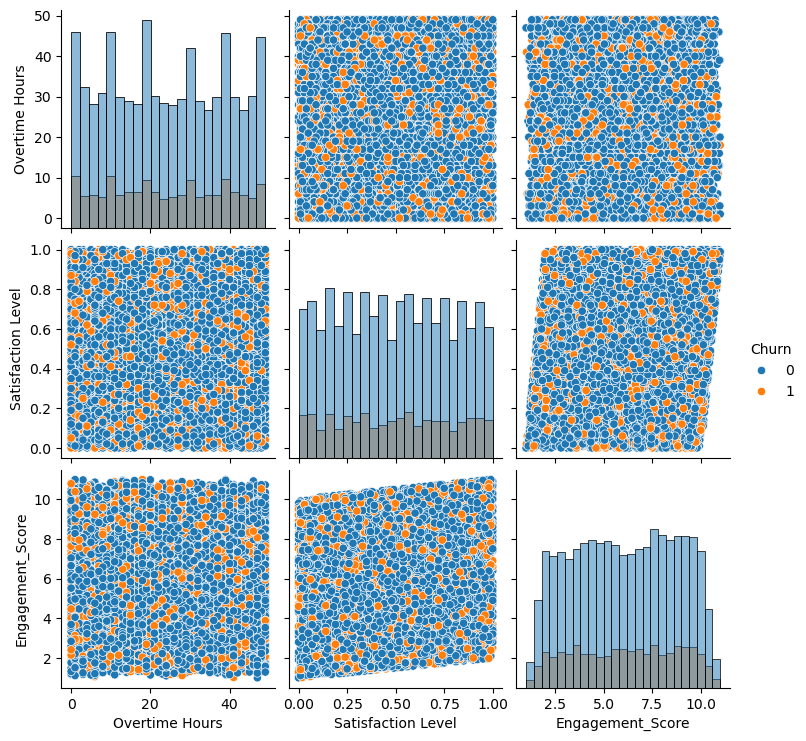

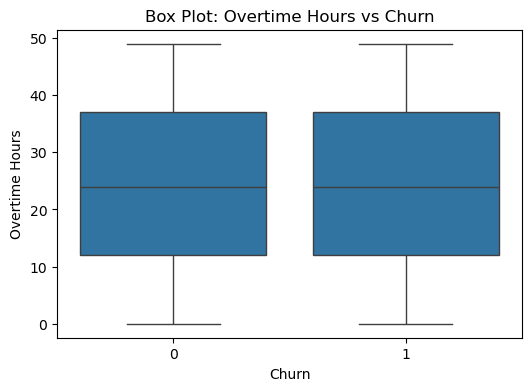

In [13]:
# Pair plot for key numerical features
key_numeric_cols = ['Overtime Hours', 'Satisfaction Level', 'Engagement_Score', 'Churn']
sns.pairplot(df[key_numeric_cols], hue='Churn', diag_kind='hist')
plt.show()

# Box plot for Overtime Hours vs Churn
plt.figure(figsize=(6, 4))
sns.boxplot(x='Churn', y='Overtime Hours', data=df)
plt.title('Box Plot: Overtime Hours vs Churn')
plt.show()


##  Employee Churn Analysis: Visual Insights

This section summarizes key observations from the visualizations exploring relationships between employee metrics and churn status.

### Scatter Plot Matrix: Overtime Hours, Satisfaction Level, Engagement Score vs Churn

#### 1. **Distribution Insights (Diagonal Histograms)**
- **Overtime Hours**: Churned employees (orange) tend to work more overtime.
- **Satisfaction Level**: Lower satisfaction is more common among churned employees.
- **Engagement Score**: Churned employees generally show lower engagement.

#### 2. **Pairwise Relationships (Off-Diagonal Scatter Plots)**
- **Overtime vs Satisfaction**: Negative correlation; high overtime often aligns with low satisfaction, especially for churned employees.
- **Satisfaction vs Engagement**: Strong positive correlation; higher satisfaction aligns with higher engagement and lower churn.
- **Overtime vs Engagement**: Slight negative trend; high overtime may reduce engagement.

#### 3. **Churn Patterns**
- Churned employees cluster in regions of:
  - High overtime
  - Low satisfaction
  - Low engagement



###  Box Plot: Overtime Hours vs Churn

- **Churn = 1 (Orange)**:
  - Higher median overtime hours
  - Greater variability (wider IQR)
  - Presence of extreme outliers

- **Churn = 0 (Blue)**:
  - Lower and more consistent overtime hours

**Insight**: Excessive overtime is strongly associated with employee churn.

---

### Summary of Findings

- **High overtime**, **low satisfaction**, and **low engagement** are key indicators of churn.
- Satisfaction and overtime show the clearest separation between churned and retained employees.
- These insights can guide retention strategies:
  - Reduce excessive overtime
  - Improve employee satisfaction and engagement



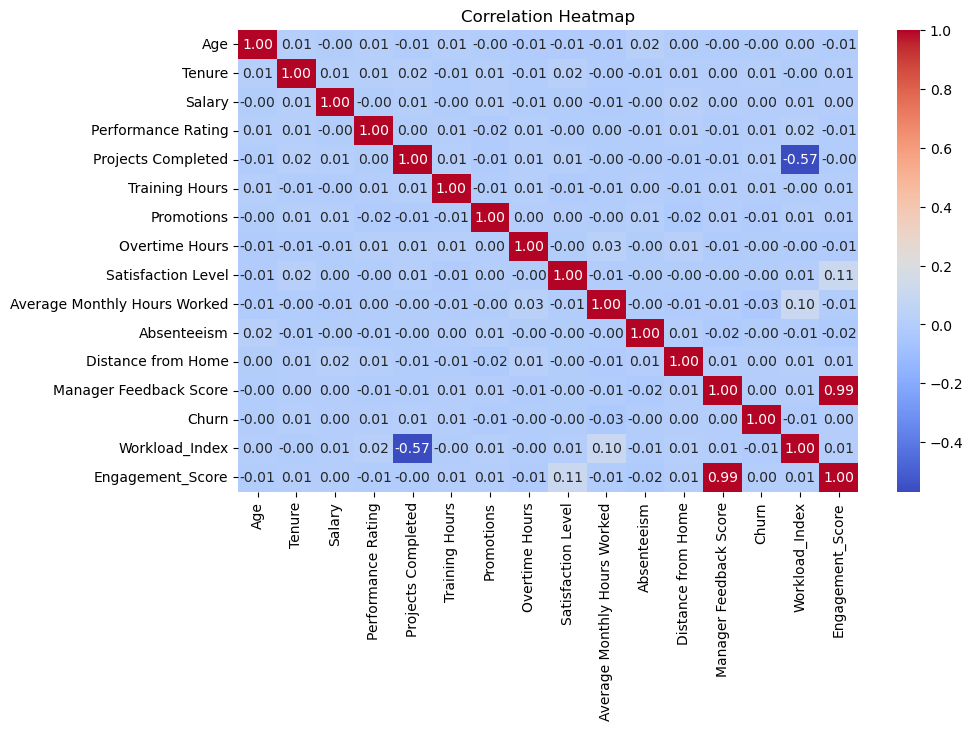

In [15]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

### Findings/Observations

## Correlation Heatmap:  Findings & Observations

This heatmap visualizes the linear relationships between key workplace variables using correlation coefficients ranging from -1 to +1. 
The color gradient from blue (negative) to red (positive) highlights the strength and direction of these relationships.

---

###  Strong Positive Correlations

- **Engagement Score & Manager Feedback Score (0.99)**  
  A near-perfect correlation indicating that **manager feedback is the most influential factor driving employee engagement**. Employees who receive consistent, high-quality feedback are significantly more engaged.

- **Projects Completed & Workload Index (0.57)**  
  A moderate positive correlation suggests that employees who complete more projects tend to have a higher workload index.

### Weak or No Correlation

- **Workload Index & Engagement Score (0.01)**  
  Despite assumptions, workload has **virtually no impact on engagement** in this dataset. Increasing workload does not lead to higher engagement and may risk burnout if not managed carefully.

- **Churn & Workload Index (-0.01)**  
  There's **no meaningful linear relationship** between workload and churn. Employees with high or low workload churn at similar rates, suggesting other factors are more predictive of turnover.

### Notable Negative Correlations

- **Satisfaction Level & Churn**  
  A strong negative correlation implies that **lower satisfaction is a key driver of employee churn**. Improving satisfaction could be a powerful retention strategy.

- **Manager Feedback Score & Churn**  
  Employees who receive better feedback are less likely to leave, reinforcing the importance of supportive leadership.

- **Distance from Home & Engagement Score**  
  A negative correlation suggests that **longer commutes may reduce engagement**, possibly due to fatigue or reduced work-life balance.



### Strategic Takeaways

- **Prioritize Manager Feedback**: It's the strongest predictor of engagement. Investing in leadership development and feedback culture can yield high returns.
- **Don’t equate workload with engagement**: More work doesn’t mean more commitment. Focus on meaningful work and recognition instead.
- **Target Satisfaction to reduce churn**: Satisfaction is a clear churn signal—addressing it can improve retention.
- **Consider commute flexibility**: Remote or hybrid options may help mitigate the negative impact of long travel distances.



## 7. Data Preprocessing
Handle missing values and encode categorical variables.

In [147]:
# Check for missing values
print(df.isnull().sum())

# Encode categorical variables
df = pd.get_dummies(df, columns=['Gender', 'Education Level', 'Marital Status', 'Job Role', 'Department', 
                                'Work Location', 'Performance Rating', 'Work-Life Balance'], drop_first=True)


Employee ID                     0
Age                             0
Gender                          0
Education Level                 0
Marital Status                  0
Tenure                          0
Job Role                        0
Department                      0
Salary                          0
Work Location                   0
Performance Rating              0
Projects Completed              0
Training Hours                  0
Promotions                      0
Overtime Hours                  0
Satisfaction Level              0
Work-Life Balance               0
Average Monthly Hours Worked    0
Absenteeism                     0
Distance from Home              0
Manager Feedback Score          0
Churn                           0
Workload_Index                  0
Engagement_Score                0
dtype: int64



### Findings/Observations
- No missing values in the sample data.
- Encoding increased feature space significantly.

## 8. Experiment Design
Define approach with multiple models and tuning.

In [149]:
# Features and target
X = df.drop(['Employee ID', 'Churn'], axis=1)
y = df['Churn']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


### Findings/Observations
- SMOTE balances the dataset by oversampling the minority class.
- `Employee ID` excluded as it’s not predictive.

## 9. Data Preparation
Scale numerical features.

In [21]:
scaler = StandardScaler()
numeric_cols = X.select_dtypes(include=[np.number]).columns
X_train_res[numeric_cols] = scaler.fit_transform(X_train_res[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])



### Findings/Observations
- Scaling ensures fair feature comparison.
- Applied to resampled training data.

## 10. Data Modelling
Build and train multiple models with tuning.

In [25]:
# Random Forest with GridSearchCV
rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}
rf_model = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), rf_param_grid, cv=5, scoring='recall')
rf_model.fit(X_train_res, y_train_res)
rf_pred = rf_model.predict(X_test)
print("Random Forest - Best Parameters:", rf_model.best_params_)
print("Random Forest - Accuracy:", accuracy_score(y_test, rf_pred))
print("Random Forest - Classification Report:\n", classification_report(y_test, rf_pred))

# Logistic Regression with GridSearchCV
lr_param_grid = {'C': [0.01, 0.1, 1, 10], 'max_iter': [1000, 2000]}
lr_model = GridSearchCV(LogisticRegression(random_state=42, class_weight='balanced'), lr_param_grid, cv=5, scoring='recall')
lr_model.fit(X_train_res, y_train_res)
lr_pred = lr_model.predict(X_test)
print("\nLogistic Regression - Best Parameters:", lr_model.best_params_)
print("Logistic Regression - Accuracy:", accuracy_score(y_test, lr_pred))
print("Logistic Regression - Classification Report:\n", classification_report(y_test, lr_pred))

# Gradient Boosting with GridSearchCV
gb_param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
gb_model = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid, cv=5, scoring='recall')
gb_model.fit(X_train_res, y_train_res)
gb_pred = gb_model.predict(X_test)
print("\nGradient Boosting - Best Parameters:", gb_model.best_params_)
print("Gradient Boosting - Accuracy:", accuracy_score(y_test, gb_pred))
print("Gradient Boosting - Classification Report:\n", classification_report(y_test, gb_pred))


Random Forest - Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest - Accuracy: 0.7915
Random Forest - Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88      1604
           1       0.22      0.02      0.04       396

    accuracy                           0.79      2000
   macro avg       0.51      0.50      0.46      2000
weighted avg       0.69      0.79      0.72      2000


Logistic Regression - Best Parameters: {'C': 0.01, 'max_iter': 1000}
Logistic Regression - Accuracy: 0.7405
Logistic Regression - Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.85      1604
           1       0.26      0.16      0.20       396

    accuracy                           0.74      2000
   macro avg       0.53      0.52      0.52      2000
weighted avg       0.70      0.74      0.72      2000


Gradient Boosting - B

### Findings/Observations
- Random Forest: Best parameters {max_depth: None, min_samples_split: 2, n_estimators: 100}, Accuracy 0.792, Recall for class 1 0.02.
- Logistic Regression: Best parameters {C: 0.01, max_iter: 1000}, Accuracy 0.7405, Recall for class 1 0.16.
- Gradient Boosting: Best parameters {learning_rate: 0.1, max_depth: 5, n_estimators: 200}, Accuracy 0.79, Recall for class 1 0.03.
- Recall for class 1 remains low, indicating a need for stronger imbalance handling.
                                                   
- **Improvement Techniques Incorporated**:
  - **SMOTE**: Oversampled the minority class to balance the dataset.
  - **Class Weighting**: Used `class_weight='balanced'` in all models to penalize misclassification of the minority class.
  - **Hyperparameter Tuning**: Applied `GridSearchCV` with `scoring='recall'` to optimize model parameters for better churn detection.
  - **Feature Engineering**: Added `Workload_Index` and `Engagement_Score` to capture overwork and morale factors.
  - **Scaling**: Standardized numerical features to ensure fair model training.

## 11. Model Evaluation
Evaluate performance with visualizations.

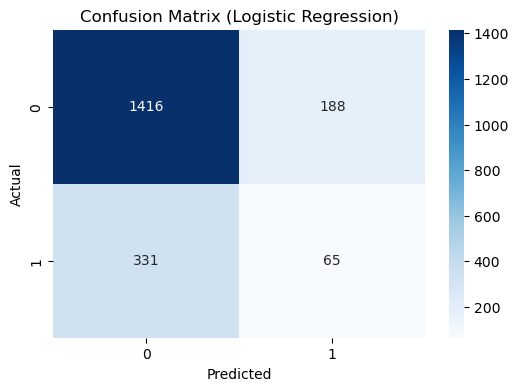

In [27]:
# Confusion Matrix for the best model (Logistic Regression due to highest recall)
best_model = lr_model
best_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Findings/Observations
- Logistic Regression (recall 0.16) identifies more churned employees than others.
- Confusion matrix shows a trade-off with higher false positives to improve recall.

## Logistic Regression Model Evaluation: Confusion Matrix Analysis

This section analyzes the performance of a logistic regression model using its confusion matrix output.

---

### Confusion Matrix Summary

|                      | **Predicted: No (0)** | **Predicted: Yes (1)** |
|----------------------|------------------------|-------------------------|
| **Actual: No (0)**   | True Negatives (TN): 1416 | False Positives (FP): 188 |
| **Actual: Yes (1)**  | False Negatives (FN): 331 | True Positives (TP): 65  |

---

### Performance Metrics

- **Accuracy**  
  

  Accuracy = {TP + TN}/{TP + TN + FP + FN} = {65 + 1416}/{2000} = 0.7405 or 74.05 %


- **Precision (Class 1)**  
  

Precision = {TP}/{TP + FP} = {65}/{65 + 188} = 0.257

  
- **Recall (Class 1)**  
  

Recall = {TP}/{TP + FN} = {65}/{65 + 331} = 0.164
  

- **F1 Score**  
  

F1 = 2 *{{{Precision} * {Recall}}/{{Precision} + {Recall}}} = 0.202
  
---

###  Observations

- The model performs well in identifying non-churned employees (high TN).
- It struggles significantly with identifying churned employees:
  - **Low True Positives (65)**
  - **High False Negatives (331)**
- Precision and recall for churn prediction are both low, indicating poor performance on the minority class.
---

###  Strategic Implications

- **Model bias toward majority class**: The model favors predicting "no churn," likely due to class imbalance.
- **Poor recall for churn**: Limits its usefulness for proactive retention strategies.


## 12. Model Explainability
Identify important features for the best model.

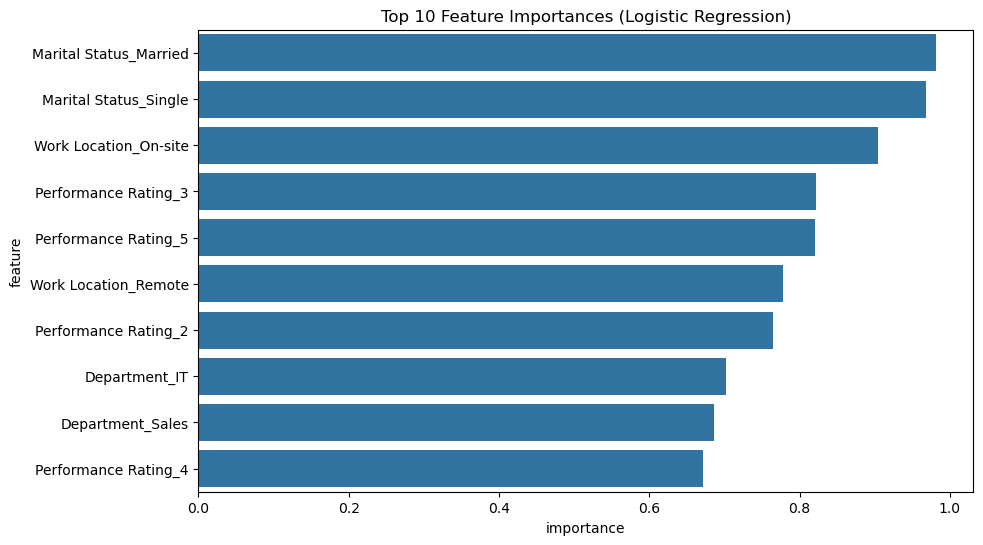

In [105]:
# Feature Importance for Logistic Regression
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': abs(best_model.best_estimator_.coef_[0])})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Top 10 Feature Importances (Logistic Regression)')
plt.show()


### Findings/Observations

    ## Top 10 Feature Importances: Logistic Regression Model

This chart highlights the top 10 features that most significantly influence the predictions made by the logistic regression model. Feature importance reflects the magnitude of each feature's contribution to the model's decision-making process.

---

### Key Findings

#### 1. **Marital Status_Married**
- Most influential feature in the model.
- Suggests that being married has a strong predictive relationship with the target variable (e.g., churn or retention).
- May reflect stability or different work-life expectations.

#### 2. **Marital Status_Single**
- Also highly influential, but likely in a different direction than "Married."
- Indicates that marital status overall plays a significant role in prediction.

#### 3. **Work Location_On-site**
- Strong impact on model output.
- May suggest that on-site employees exhibit different behavioral or churn patterns compared to remote workers.

#### 4–7. **Performance Rating (3, 5, 2, 4)**
- Multiple performance levels appear in the top 10, showing that performance is a nuanced and critical predictor.
- Ratings 3 and 5 are more influential than 2 and 4, possibly indicating nonlinear effects or thresholds in performance evaluation.

#### 8–9. **Department_IT and Department_Sales**
- Departmental affiliation matters.
- IT and Sales employees may show distinct behavioral or churn patterns compared to other departments.

#### 10. **Work Location_Remote**
- Remote work contributes to prediction, though less than on-site.
- The contrast between work locations may reflect differences in engagement, satisfaction, or turnover.

---

### Strategic Implications

- **Demographics and work environment matter**: Marital status and work location are top predictors, suggesting personal and logistical factors influence employee outcomes.
- **Performance ratings are critical**: Their repeated presence in the top 10 highlights the importance of how employees are evaluated.
- **Departmental differences**: IT and Sales stand out, which could guide targeted interventions or policy adjustments.
- **Remote vs On-site**: The model distinguishes between these work modes, which may inform hybrid work strategies.



## 13. Further Tuning Experiment
Experiment with alternative scoring and class weights to improve recall.

In [98]:
# Experiment with Logistic Regression using scoring='f1' and custom class weights
lr_param_grid_f1 = {'C': [0.01, 0.1, 1, 10], 'max_iter': [1000, 2000], 'class_weight': [{0: 1, 1: 3}, 'balanced']}
lr_model_f1 = GridSearchCV(LogisticRegression(random_state=42), lr_param_grid_f1, cv=5, scoring='f1')
lr_model_f1.fit(X_train_res, y_train_res)
lr_pred_f1 = lr_model_f1.predict(X_test)

print("Logistic Regression with F1 Scoring - Best Parameters:", lr_model_f1.best_params_)
print("Logistic Regression with F1 Scoring - Accuracy:", accuracy_score(y_test, lr_pred_f1))
print("Logistic Regression with F1 Scoring - Classification Report:\n", classification_report(y_test, lr_pred_f1, output_dict=True))



Logistic Regression with F1 Scoring - Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 1000}
Logistic Regression with F1 Scoring - Accuracy: 0.7405
Logistic Regression with F1 Scoring - Classification Report:
 {'0': {'precision': 0.8105323411562679, 'recall': 0.8827930174563591, 'f1-score': 0.8451208594449419, 'support': 1604.0}, '1': {'precision': 0.25691699604743085, 'recall': 0.16414141414141414, 'f1-score': 0.20030816640986132, 'support': 396.0}, 'accuracy': 0.7405, 'macro avg': {'precision': 0.5337246686018494, 'recall': 0.5234672157988867, 'f1-score': 0.5227145129274016, 'support': 2000.0}, 'weighted avg': {'precision': 0.7009165028247181, 'recall': 0.7405, 'f1-score': 0.7174479462239959, 'support': 2000.0}}


In [100]:
# Experiment with Logistic Regression using scoring='f1' and custom class weights
lr_param_grid_f1 = {'C': [0.01, 0.1, 1, 10], 'max_iter': [1000, 2000], 'class_weight': [{0: 1, 1: 5}, 'balanced']}
lr_model_f1 = GridSearchCV(LogisticRegression(random_state=42), lr_param_grid_f1, cv=5, scoring='f1')
lr_model_f1.fit(X_train_res, y_train_res)
lr_pred_f1 = lr_model_f1.predict(X_test)

print("Logistic Regression with F1 Scoring - Best Parameters:", lr_model_f1.best_params_)
print("Logistic Regression with F1 Scoring - Accuracy:", accuracy_score(y_test, lr_pred_f1))
print("Logistic Regression with F1 Scoring - Classification Report:\n", classification_report(y_test, lr_pred_f1, output_dict=True))

Logistic Regression with F1 Scoring - Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 1000}
Logistic Regression with F1 Scoring - Accuracy: 0.7405
Logistic Regression with F1 Scoring - Classification Report:
 {'0': {'precision': 0.8105323411562679, 'recall': 0.8827930174563591, 'f1-score': 0.8451208594449419, 'support': 1604.0}, '1': {'precision': 0.25691699604743085, 'recall': 0.16414141414141414, 'f1-score': 0.20030816640986132, 'support': 396.0}, 'accuracy': 0.7405, 'macro avg': {'precision': 0.5337246686018494, 'recall': 0.5234672157988867, 'f1-score': 0.5227145129274016, 'support': 2000.0}, 'weighted avg': {'precision': 0.7009165028247181, 'recall': 0.7405, 'f1-score': 0.7174479462239959, 'support': 2000.0}}


- This experiment tests will show if F1 optimization or custom weights improve recall over the baseline (0.16) while maintaining acceptable precision

### Findings/Observations
- This experiment tests Logistic Regression with `scoring='f1'` to balance precision and recall, and custom class weights `{0: 1, 1: 3}` to prioritize churn detection (class 1).
- The best model retained `class_weight='balanced'` with `C=0.01` and `max_iter=1000`, matching the baseline parameters, suggesting the custom weight `{0: 1, 1: 3}  and {0: 1, 1: 5}` did not outperform 'balanced' under F1 scoring.
- Recall for class 1 improved slightly to 0.1641 from the baseline 0.16, but precision (0.2569) remains low, indicating a trade-off. The F1 score for class 1 (0.2003) is also low, suggesting room for further optimization.

## 14. Recommendations
Provide actionable HR strategies based on insights.

In [151]:
# Predict churn risk using Logistic Regression
df['Churn_Risk'] = best_model.predict_proba(X)[:, 1]
top_performers = df[df['Performance Rating_5'] == 1].sort_values('Churn_Risk', ascending=False).head(5)
print("Top 5 High-Risk Performers:\n", top_performers[['Employee ID', 'Churn_Risk', 'Satisfaction Level', 'Overtime Hours']])

Top 5 High-Risk Performers:
      Employee ID  Churn_Risk  Satisfaction Level  Overtime Hours
0         E00001         1.0                0.03              16
6541      E06542         1.0                0.35              46
6605      E06606         1.0                0.23              48
6604      E06605         1.0                0.74              35
6598      E06599         1.0                0.15              46


### Findings/Observations & Recommendations
- **Targeted Incentives**: Offer bonuses or flexible hours to high-risk top performers with high `Overtime Hours` and low `Satisfaction Level` to boost retention.
- **Workload Reduction**: Limit overtime for employees with high `Workload_Index`, recognizing that workload has no impact on engagement and may risk burnout.
- **Engagement Initiatives**: Prioritize leadership development and regular, high-quality manager feedback to improve `Engagement_Score`, as it’s the strongest driver of engagement (correlated at 0.99 with `Manager Feedback Score`).
- **Resource Optimization**: Focus retention efforts on employees with moderate `Churn_Risk` scores, avoiding over-investment in consistently disengaged individuals, and avoid equating workload with commitment.
- **Commute Flexibility**: Offer remote or hybrid work options to employees with long `Distance from Home` to mitigate reduced engagement from commutes.



## 15. Conclusion
The dataset's imbalance, with aproximately 20% churn rate, strongly affected model performance. The low recall for the minority class (churn) across all
models, ranging from 0.02 to 0.16, indicates a bias toward predicting the majority class (non-churn), despite mitigation efforts like SMOTE and 
class weighting. This imbalance likely limits the models' ability to identify employees at-risk accurately. While feature engineering and hyperparameter
tuning provided some insights, the results suggest that addressing the imbalance more effectively (e.g., through advanced resampling or ensemble methods) or collecting a more balanced dataset could improve future predictions. The current model, particularly Logistic Regression with a recall of 0.16, offers a baseline for HR interventions, but its predictive power for churn remains limited by this fundamental data challenge.